## Goal:

Here we test the functions: `lbfgsb` in the `Screenkhorn` class.

In [48]:
# NUMPY
import numpy as np
np.random.seed(3946)
# MATPLOTLIB
import matplotlib.pyplot as plt
plt.style.context('dark_background')
%matplotlib inline 
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (16, 6)}
plt.rcParams.update(params)

# SEABORN 
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

# SKLEARN 
from sklearn.metrics import pairwise_distances

# WARNINGS
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# TIME
from time import time 

# PATH 
import sys
path_files = '/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/'
sys.path.insert(0, path_files) 


# POT
import ot
from ot import sinkhorn, emd

# GREENKHORN 
from ot.bregman import greenkhorn

# SCREENKHORN
from screenkhorn.base import Screenkhorn


## Data generation

In [49]:
n_1 = 15000# nb samples
n_2 = 15000
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n_1, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n_2, mu_t, cov_t)

a = np.ones((n_1,)) / n_1
b = np.ones((n_2,)) / n_2  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()
reg = 0.09
K = np.exp(-M/reg)

In [50]:
lower_bound_epsilon = M.max()/806
lower_bound_epsilon

0.0012406947890818859

## Sinkhorn 

In [51]:
tic = time()
P_sink = sinkhorn(a, b, M, reg, log=True)
P_star = P_sink[0]
outputs_dict = P_sink[1]
exp_u_star = outputs_dict['u']
exp_v_star = outputs_dict['v']
time_sink = time() - tic
print("time of Sinkhorn algorithm is %s" %time_sink)

time of Sinkhorn algorithm is 12.643258810043335


## Bounds of $\varepsilon \in (\varepsilon_{\min}, \varepsilon_{\max})$


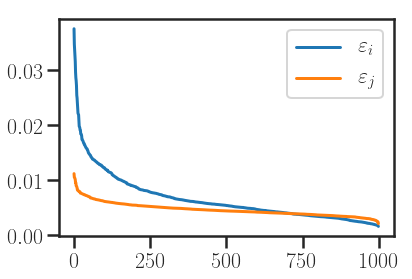

In [14]:
epsilons_a = np.sqrt(a / K.sum(axis=1))
epsilons_a_sort = np.sort(epsilons_a)[::-1]
epsilons_b = np.sqrt(b / K.T.sum(axis=1))
epsilons_b_sort = np.sort(epsilons_b)[::-1]
plt.plot(epsilons_a_sort, label=r'$\varepsilon_i$')
plt.plot(epsilons_b_sort, label=r'$\varepsilon_j$')
plt.legend();

#### Choice of epsilon

In [15]:
epsilons_ab = np.sort(np.hstack([epsilons_a, epsilons_b]))[::-1]
epsilon_mid = (max(epsilons_ab) - min(epsilons_ab))/2+ min(epsilons_ab)
epsilon_min = min(epsilons_ab)
epsilon_max = max(epsilons_ab)

epsilon_min, epsilon_mid, epsilon_max

(0.0016217069775169572, 0.01959214842396386, 0.037562589870410765)

In [52]:
# theoretical epsilon_min and epsilon_max
epsilon_min_th = min((np.sqrt(a/K.sum(axis=1))).min(), (np.sqrt(b/K.T.sum(axis=1))).min())
epsilon_max_th = max((np.sqrt(a/K.sum(axis=1))).max(), (np.sqrt(b/K.T.sum(axis=1))).max())

# epsilon_active = epsilon_max_th
epsilon_active = epsilon_min_th
# epsilon_active = (epsilon_max_th - epsilon_min_th)/3 + epsilon_max_th

epsilon_min_th, epsilon_max_th, epsilon_active

(8.413420472018947e-05, 0.002097837552728335, 8.413420472018947e-05)

In [53]:
I_active = np.where(a >= epsilon_active**2 * K.sum(axis=1))[0].tolist()
Ic_active = np.where(a < epsilon_active**2 * K.sum(axis=1))[0].tolist()

J_active = np.where(b >= epsilon_active**2 * K.T.sum(axis=1))[0].tolist()
Jc_active = np.where(b < epsilon_active**2 * K.T.sum(axis=1))[0].tolist()

len(I_active), len(J_active)

(15000, 15000)

#### Initial points and a priori active sets

In [54]:
u0 = np.full(n_1, 1.0) #1.2*epsilon_min_th)
v0 = np.full(n_2, 1.0) #1.2*epsilon_min_th)

In [62]:
tic = time()
screenkhorn = Screenkhorn(a, b, M, reg, 0.0, I_active, J_active)
toc_initial = time() - tic
toc_initial

12.662734746932983

## L-BFGS-B

In [97]:
tic = time()
# screenkhorn = Screenkhorn(a, b, M, reg, 0.0, I_active, J_active)
lbfgsb = screenkhorn.lbfgsb(u0, v0)
toc_bfgs = time() - tic
toc_bfgs

Certificate is achieved
Time spending during the restricted Skinkhorn is 2.0696587562561035


2.299492835998535

In [98]:
time_sink, toc_bfgs, time_sink / toc_bfgs,  toc_bfgs / time_sink
# (0.5018818378448486, 2.3092141151428223, 4.601111140141898) 
# (0.5108699798583984, 1.788315773010254, 3.5005301613258513)

(12.643258810043335, 2.299492835998535, 5.498281452376479, 0.1818750110669176)

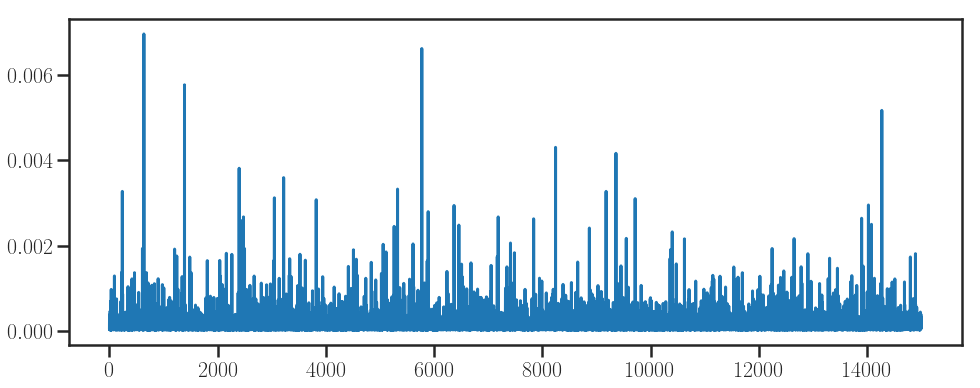

In [86]:
plt.plot(exp_u_star);

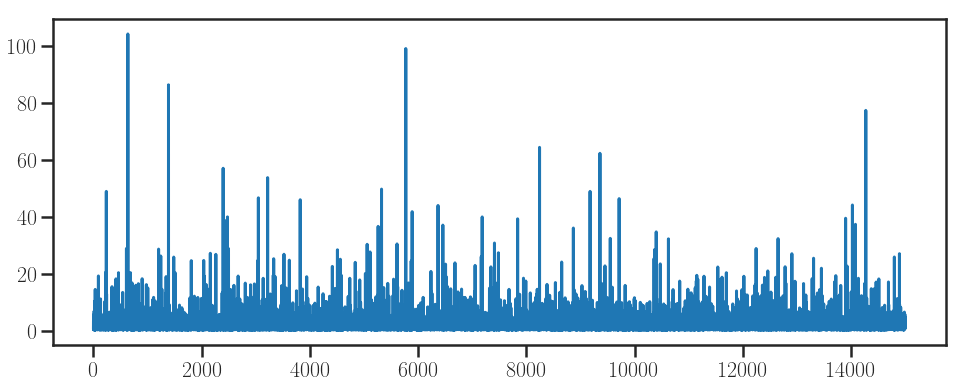

In [87]:
plt.plot(lbfgsb[0]);

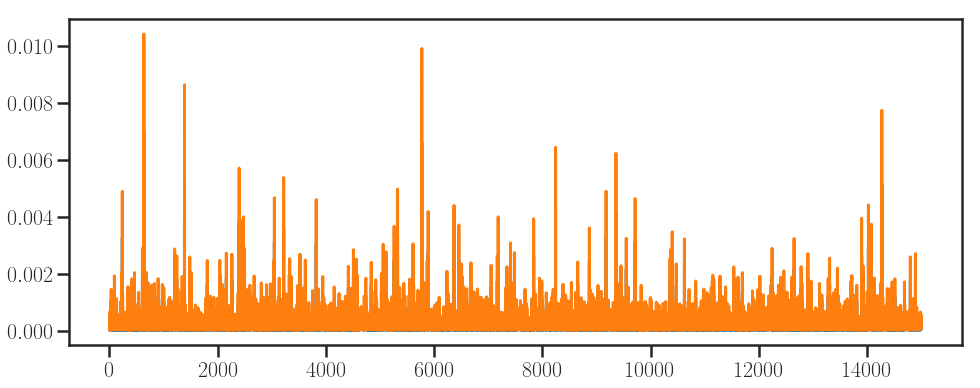

In [89]:
plt.plot(exp_u_star)
plt.plot(lbfgsb[0]/1e4);

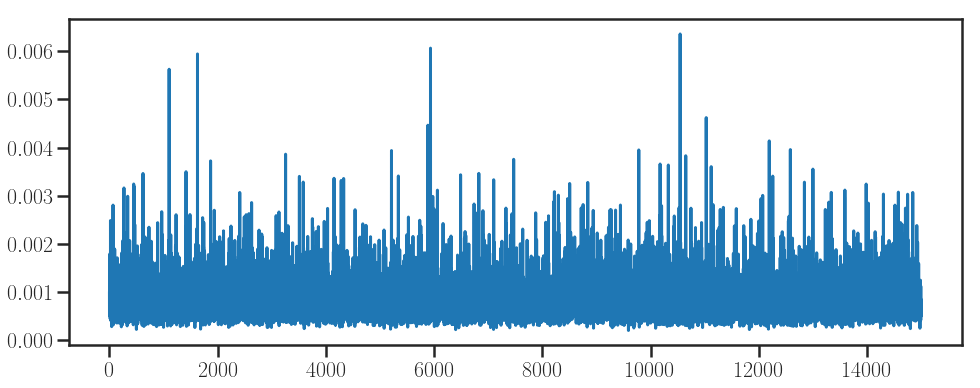

In [90]:
plt.plot(exp_v_star);

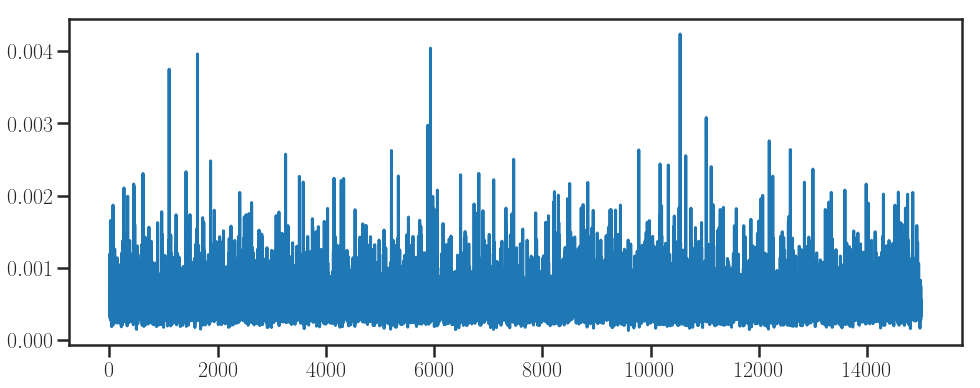

In [91]:
plt.plot(lbfgsb[1]*1e4);

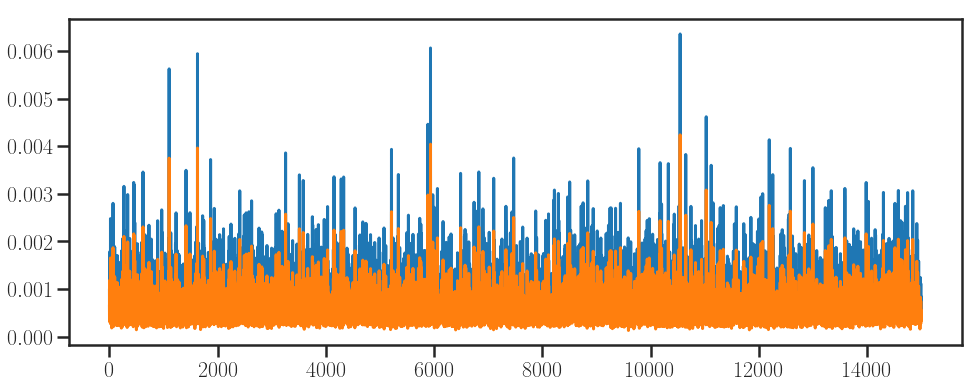

In [92]:
plt.plot(exp_v_star)
plt.plot(lbfgsb[1]*1e4);

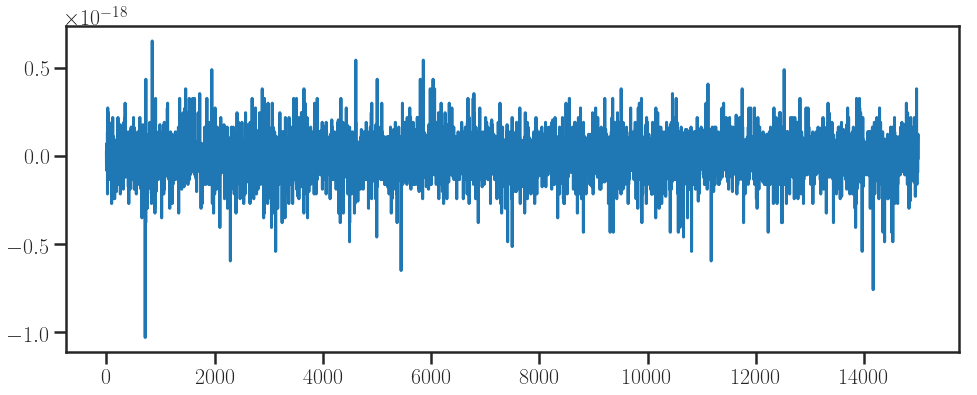

In [93]:
# Gradient w.r.t. u
plt.plot(lbfgsb[3]['grad'][:len(I_active)]);

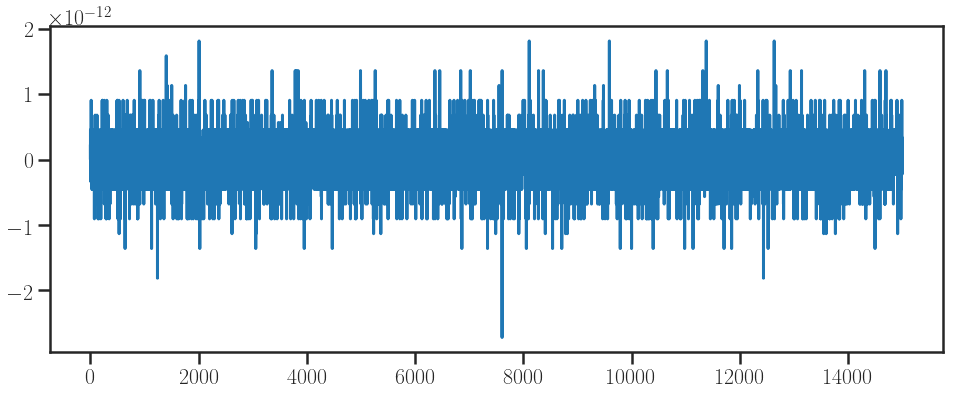

In [94]:
# Gradient w.r.t. v
plt.plot(lbfgsb[3]['grad'][len(I_active):]);

In [84]:
# sinkhorn
P_star = np.diag(exp_u_star) @ K @ np.diag(exp_v_star)
a_star = P_star @ np.ones(n_2)
b_star = P_star.T @ np.ones(n_1)

# screenkhorn via lbfgsb
usc_bfgs = lbfgsb[0]
vsc_bfgs = lbfgsb[1]
P_sc_bfgs = np.diag(usc_bfgs) @ K @ np.diag(vsc_bfgs)
a_sc_bfgs = P_sc_bfgs @ np.ones(n_2)
b_sc_bfgs = P_sc_bfgs.T @ np.ones(n_1)

print("sum of the marginals in sinkhorn are: %s, \t %s" %(sum(a_star), sum(b_star)))
print("\t")
print("sum of the marginals in screenkhorn are: %s, \t %s" %(sum(a_sc_bfgs), sum(b_sc_bfgs)))
print("\t")
print("Difference in sinkhorn: %s \t %s:" %(abs(1 - sum(a_star)), abs(1 - sum(b_star))))
print("\t")
print("Difference in screenkhorn: %s \t  %s:" %(abs(1 - sum(a_sc_bfgs)), abs(1 - sum(b_sc_bfgs))))
print("\t")
print("Frobenius norm of difference solution matrices %s " %np.linalg.norm(P_star - P_sc_bfgs,'fro'))
print('\t')
print("Max norm of difference solution matrices %s "  %abs(P_star - P_sc_bfgs).max())

sum of the marginals in sinkhorn are: 0.9999999999999095, 	 0.9999999999999082
	
sum of the marginals in screenkhorn are: 0.9999999999999095, 	 0.9999999999999082
	
Difference in sinkhorn: 9.048317650695026e-14 	 9.181544413650045e-14:
	
Difference in screenkhorn: 9.048317650695026e-14 	  9.181544413650045e-14:
	
Frobenius norm of difference solution matrices 3.288492716143723e-19 
	
Max norm of difference solution matrices 4.698385879301197e-22 
